# Universidad de O'Higgins

## Escuela de Ingeniería
## COM4402: Introducción a Inteligencia Artificial

### **Tarea 2: Clasificación de Dígitos Manuscritos con Redes Neuronales**

### Estudiante: José Tomás García Risco

El objetivo de esta tarea es utilizar redes neuronales en un problema de clasificación de dígitos. Se utilizará el conjunto de datos Optical Recognition of Handwritten Digits Data Set. Este conjunto tiene 64 características, con 10 clases y 5620 muestras en total. La base de datos estará disponible en U-Campus.

Las redes a ser entrenadas tienen la siguiente estructura: capa de entrada de dimensionalidad 64 (correspondiente a los datos de entrada), capas ocultas (una o dos) y capa de salida con 10 neuronas y función de activación softmax. La función de loss (pérdida) es entropía cruzada. El optimizador que se
debe usar es Adam. La función softmax está implícita al usar la función de pérdida CrossEntropyLoss de PyTorch (**no se debe agregar softmax a la salida de la red**).

Se usará PyTorch para entrenar y validar la red neuronal que implementa el clasificador de dígitos. Se analizará los efectos de cambiar el tamaño de la red (número de capas ocultas y de neuronas en estas
capas) y la función de activación.

El siguiente código base debe ser usado para realizar las actividades pedidas.

## Observación: Antes de ejecutar su código, active el uso de GPU en Google Colab para acelerar el proceso de entrenamiento.

### Para esto: vaya a "Entorno de Ejecución" en el menú superior, haga click en "Cambiar tipo de entorno de ejecución", y seleccionar/verificar "GPU" en "Acelerador de Hardware"

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

## Subir datasets de dígitos (train)

In [ ]:
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt

## Leer dataset de dígitos

In [3]:
column_names = ["feat" + str(i) for i in range(64)]
column_names.append("class")

In [ ]:
df_train_val = pd.read_csv('1_digits_train.txt', names = column_names)
df_train_val

In [ ]:
df_test = pd.read_csv('1_digits_test.txt', names = column_names)
df_test

In [6]:
df_train, df_val = train_test_split(df_train_val, test_size = 0.3, random_state = 10)

In [ ]:
scaler = StandardScaler().fit(df_train.iloc[:,0:64])
df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
df_test.iloc[:,0:64] = scaler.transform(df_test.iloc[:,0:64])

In [ ]:
df_train

# Modelo 10 neuronas en la capa oculta, usando función de activación ReLU y 1000 épocas como máximo


##Modelo

In [94]:
model = nn.Sequential(
    nn.Linear(64, 10),
    nn.ReLU(),
    nn.Linear(10, 10)
)

In [95]:
device = torch.device('cuda')

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Crear datasets y dataloaders para pytorch (train)

In [96]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:64].astype(np.float32)
labels_train = df_train.to_numpy()[:,64].astype(int)
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:64].astype(np.float32)
labels_val = df_val.to_numpy()[:,64].astype(int)
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:,64].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]

In [97]:
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

## Entrenamiento

In [98]:
start = time.time()

best_val_accuracy = 0
loss_train = []
loss_val = []
accuracy_train = []  # Para almacenar el accuracy en entrenamiento
accuracy_val = []    # Para almacenar el accuracy en validación
epochs = []

early_stopping_patience = 10 #numero de veces que puede haber perdida
min_loss_val = float('inf')
patience = 0

# loop
for epoch in range(1000):
  loss_train_batches = []
  loss_val_batches = []
  accuracy_train_batches = []  # Para almacenar el accuracy en cada lote de entrenamiento
  accuracy_val_batches = []    # Para almacenar el accuracy en cada lote de validación
  # Entrenamiento
  model.train()
  # Debemos recorrer cada batch (lote de los datos)
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward() # backpropagation
    optimizer.step()

    # Por completar: calcule la pérdida de validación y acurracy en el batch actual
    loss_train_batches.append(loss.item())
    accuracy_batch = accuracy_score(labels.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy())
    accuracy_train_batches.append(accuracy_batch)  # Almacena la precisión del lote

  loss_train.append(np.mean(loss_train_batches))

  model.eval()
  true_labels_train = []
  predicted_labels_train = []
  with torch.no_grad():
    # Iteramos dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases
      outputs = model(inputs)              # Obtenemos predicciones
      # Guardamos la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())
      accuracy_batch = accuracy_score(labels.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy())
      accuracy_val_batches.append(accuracy_batch)  # Almacena la precisión del lote

  # Guardamos el Loss de validación de la época actual
  loss_val_epoch = np.mean(loss_val_batches)
  loss_val.append(loss_val_epoch)  # Guardar la pérdida de validación en la época actual

  epoch_train_accuracy = np.mean(accuracy_train_batches)
  epoch_val_accuracy = np.mean(accuracy_val_batches)
  accuracy_train.append(epoch_train_accuracy)
  accuracy_val.append(epoch_val_accuracy)

  if epoch_val_accuracy > best_val_accuracy:
      best_val_accuracy = epoch_val_accuracy
      torch.save(model.state_dict(), 'best_model.pth')
  if loss_val_epoch < min_loss_val:
      min_loss_val = loss_val_epoch
      patience = 0  # Restablecer el contador de paciencia si la pérdida de validación mejora
  else:
      patience += 1

  # Guardamos la época
  epochs.append(epoch)

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f accuracy train: %.4f accuracy val: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch], accuracy_train[epoch], accuracy_val[epoch])))

  if patience >= early_stopping_patience:
        print(f"Early stopping after {epoch} epochs")
        break  # Detener el entrenamiento si no hay mejora en la pérdida de validación

end = time.time()
print('Finished Training, total time %f seconds' % (end - start))

Epoch: 0, train loss: 2.2107, val loss: 2.1086 accuracy train: 0.1331 accuracy val: 0.1828
Epoch: 1, train loss: 2.0285, val loss: 1.9241 accuracy train: 0.2329 accuracy val: 0.3324
Epoch: 2, train loss: 1.8461, val loss: 1.7342 accuracy train: 0.3718 accuracy val: 0.4642
Epoch: 3, train loss: 1.6650, val loss: 1.5721 accuracy train: 0.4819 accuracy val: 0.5616
Epoch: 4, train loss: 1.4895, val loss: 1.3983 accuracy train: 0.5766 accuracy val: 0.6249
Epoch: 5, train loss: 1.3224, val loss: 1.2357 accuracy train: 0.6496 accuracy val: 0.6696
Epoch: 6, train loss: 1.1727, val loss: 1.0888 accuracy train: 0.6916 accuracy val: 0.7189
Epoch: 7, train loss: 1.0375, val loss: 0.9684 accuracy train: 0.7367 accuracy val: 0.7631
Epoch: 8, train loss: 0.9192, val loss: 0.8582 accuracy train: 0.7757 accuracy val: 0.8036
Epoch: 9, train loss: 0.8140, val loss: 0.7637 accuracy train: 0.8151 accuracy val: 0.8284
Epoch: 10, train loss: 0.7223, val loss: 0.6735 accuracy train: 0.8410 accuracy val: 0.857

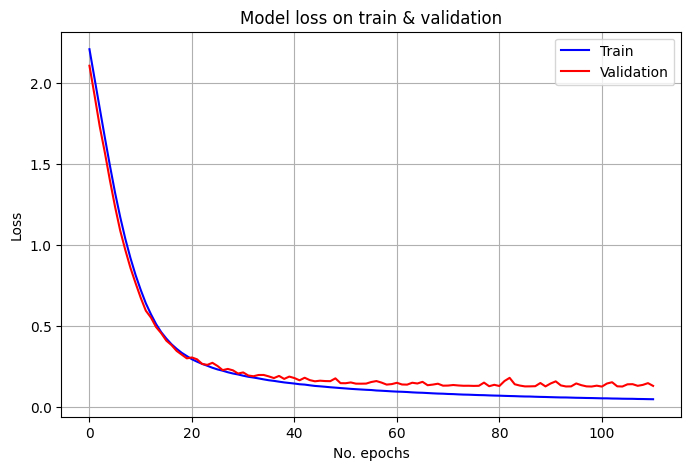

In [99]:
import matplotlib.pyplot as plt

# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('Model loss on train & validation')
plt.xlabel('No. epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss_train, 'b', label = 'Train')
plt.plot(epochs, loss_val, 'r', label = 'Validation')
plt.grid()
plt.legend()

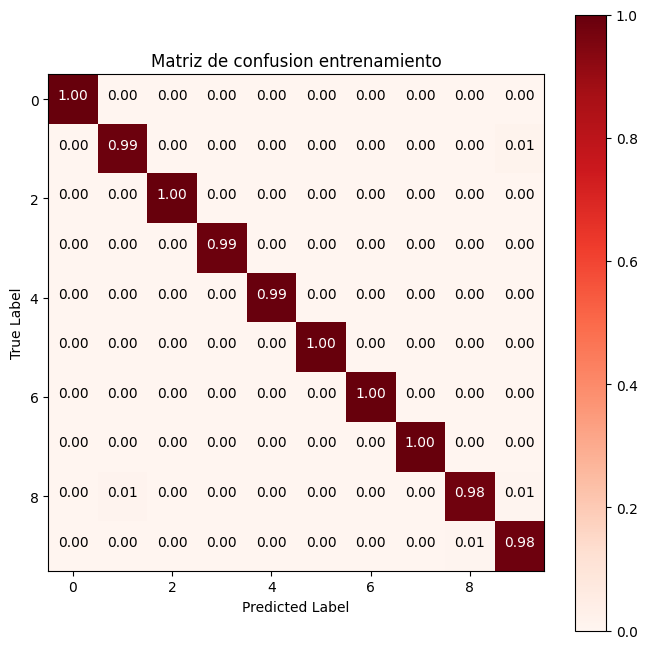

In [100]:
true_labels = []
predicted_labels = []
model.eval()
with torch.no_grad():
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(outputs.argmax(dim=1).cpu().numpy())

conf_matrix = confusion_matrix(true_labels, predicted_labels)
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
plt.imshow(normalized_conf_matrix, interpolation='nearest', cmap='Reds')
plt.title('Matriz de confusion entrenamiento')
plt.colorbar()

for i in range(normalized_conf_matrix.shape[0]):
    for j in range(normalized_conf_matrix.shape[1]):
        plt.text(j, i, "{:.2f}".format(normalized_conf_matrix[i, j]), horizontalalignment='center', color='white' if i == j else 'black')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

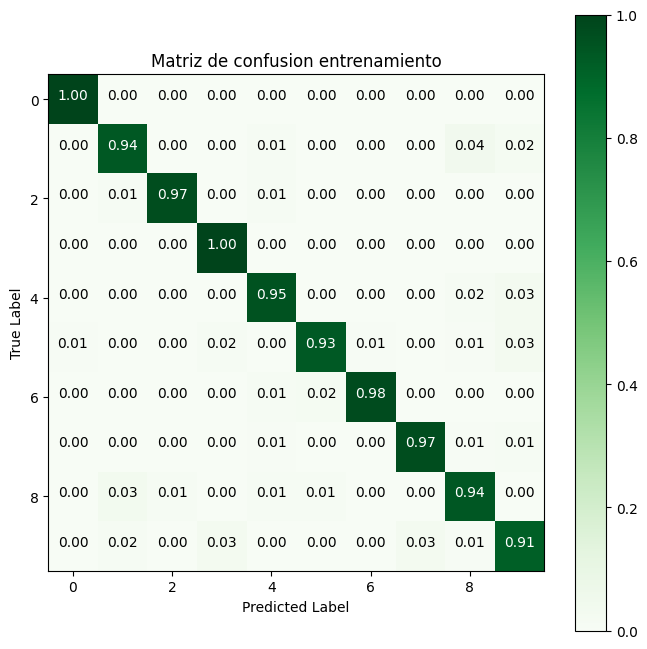

In [101]:
true_labels = []
predicted_labels = []

model.eval()

with torch.no_grad():
    for data in dataloader_val:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(outputs.argmax(dim=1).cpu().numpy())

conf_matrix = confusion_matrix(true_labels, predicted_labels)
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
plt.imshow(normalized_conf_matrix, interpolation='nearest', cmap='Greens')
plt.title('Matriz de confusion entrenamiento')
plt.colorbar()

for i in range(normalized_conf_matrix.shape[0]):
    for j in range(normalized_conf_matrix.shape[1]):
        plt.text(j, i, "{:.2f}".format(normalized_conf_matrix[i, j]), horizontalalignment='center', color='white' if i == j else 'black')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

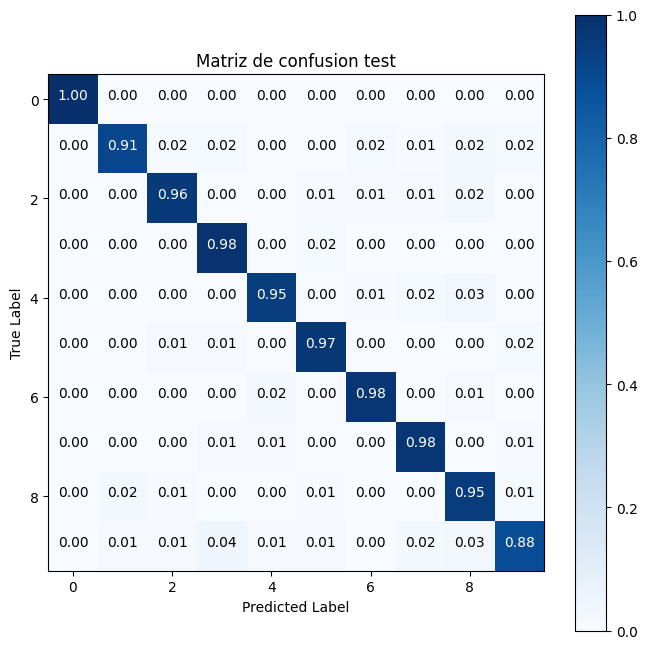

In [102]:
true_labels_test = []
predicted_labels_test = []

# Load the best model's state dictionary
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)  # Move the model to the same device used during training
model.eval()

with torch.no_grad():
    for data in dataloader_test:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)  # Use 'model' to make predictions, not 'best_model'

        true_labels_test.extend(labels.cpu().numpy())
        predicted_labels_test.extend(outputs.argmax(dim=1).cpu().numpy())

conf_matrix_test = confusion_matrix(true_labels_test, predicted_labels_test)

normalized_conf_matrix_test = conf_matrix_test.astype('float') / conf_matrix_test.sum(axis=1)[:, np.newaxis]

accuracy_test = accuracy_score(true_labels_test, predicted_labels_test)

plt.figure(figsize=(8, 8))
plt.imshow(normalized_conf_matrix_test, interpolation='nearest', cmap='Blues')  # You can choose a different colormap
plt.title('Matriz de confusion test')
plt.colorbar()

# Display the accuracy values within the matrix
for i in range(normalized_conf_matrix_test.shape[0]):
    for j in range(normalized_conf_matrix_test.shape[1]):
        plt.text(j, i, "{:.2f}".format(normalized_conf_matrix_test[i, j]), horizontalalignment='center', color='white' if i == j else 'black')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Modelo 40 neuronas en la capa oculta y funcíon de activación ReLU, y 1000 épocas como máximo


##Modelo

In [103]:
model = nn.Sequential(
    nn.Linear(64, 40),  # Capa de entrada con 64 neuronas y capa oculta con 40 neuronas
    nn.ReLU(),  # Función de activación ReLU
    nn.Linear(40, 10)  # Capa oculta con 40 neuronas y capa de salida con 10 neuronas (ajusta la salida según tus necesidades)
)

In [104]:
device = torch.device('cuda')

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Entrenamiento

In [105]:
start = time.time()

best_val_accuracy = 0
loss_train = []
loss_val = []
accuracy_train = []  # Para almacenar el accuracy en entrenamiento
accuracy_val = []    # Para almacenar el accuracy en validación
epochs = []

early_stopping_patience = 10 #numero de veces que puede haber perdida
min_loss_val = float('inf')
patience = 0

# loop
for epoch in range(1000):

  loss_train_batches = []
  loss_val_batches = []
  accuracy_train_batches = []  # Para almacenar el accuracy en cada lote de entrenamiento
  accuracy_val_batches = []    # Para almacenar el accuracy en cada lote de validación
  # Entrenamiento
  model.train()
  # Debemos recorrer cada batch (lote de los datos)
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward() # backpropagation
    optimizer.step()

    # Por completar: calcule la pérdida de validación y acurracy en el batch actual
    loss_train_batches.append(loss.item())
    accuracy_batch = accuracy_score(labels.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy())
    accuracy_train_batches.append(accuracy_batch)  # Almacena la precisión del lote

  loss_train.append(np.mean(loss_train_batches))

  model.eval()

  true_labels_train = []
  predicted_labels_train = []

  with torch.no_grad():
    # Iteramos dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases
      outputs = model(inputs)              # Obtenemos predicciones



      # Guardamos la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())
      accuracy_batch = accuracy_score(labels.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy())
      accuracy_val_batches.append(accuracy_batch)  # Almacena la precisión del lote

  # Guardamos el Loss de validación de la época actual
  loss_val_epoch = np.mean(loss_val_batches)
  loss_val.append(loss_val_epoch)  # Guardar la pérdida de validación en la época actual

  epoch_train_accuracy = np.mean(accuracy_train_batches)
  epoch_val_accuracy = np.mean(accuracy_val_batches)
  accuracy_train.append(epoch_train_accuracy)
  accuracy_val.append(epoch_val_accuracy)

  if epoch_val_accuracy > best_val_accuracy:
      best_val_accuracy = epoch_val_accuracy
      torch.save(model.state_dict(), 'best_model.pth')
  if loss_val_epoch < min_loss_val:
      min_loss_val = loss_val_epoch
      patience = 0  # Restablecer el contador de paciencia si la pérdida de validación mejora
  else:
      patience += 1

  # Guardamos la época
  epochs.append(epoch)

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f accuracy train: %.4f accuracy val: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch], accuracy_train[epoch], accuracy_val[epoch])))

  if patience >= early_stopping_patience:
        print(f"Early stopping after {epoch} epochs")
        break  # Detener el entrenamiento si no hay mejora en la pérdida de validación

end = time.time()
print('Finished Training, total time %f seconds' % (end - start))

Epoch: 0, train loss: 2.1318, val loss: 1.9107 accuracy train: 0.3661 accuracy val: 0.6747
Epoch: 1, train loss: 1.6922, val loss: 1.4379 accuracy train: 0.7566 accuracy val: 0.8208
Epoch: 2, train loss: 1.2270, val loss: 0.9971 accuracy train: 0.8270 accuracy val: 0.8635
Epoch: 3, train loss: 0.8466, val loss: 0.6887 accuracy train: 0.8703 accuracy val: 0.8976
Epoch: 4, train loss: 0.5990, val loss: 0.5093 accuracy train: 0.9043 accuracy val: 0.9180
Epoch: 5, train loss: 0.4460, val loss: 0.3836 accuracy train: 0.9258 accuracy val: 0.9403
Epoch: 6, train loss: 0.3494, val loss: 0.3099 accuracy train: 0.9407 accuracy val: 0.9466
Epoch: 7, train loss: 0.2863, val loss: 0.2611 accuracy train: 0.9458 accuracy val: 0.9488
Epoch: 8, train loss: 0.2428, val loss: 0.2276 accuracy train: 0.9514 accuracy val: 0.9530
Epoch: 9, train loss: 0.2123, val loss: 0.1954 accuracy train: 0.9579 accuracy val: 0.9567
Epoch: 10, train loss: 0.1886, val loss: 0.1929 accuracy train: 0.9609 accuracy val: 0.953

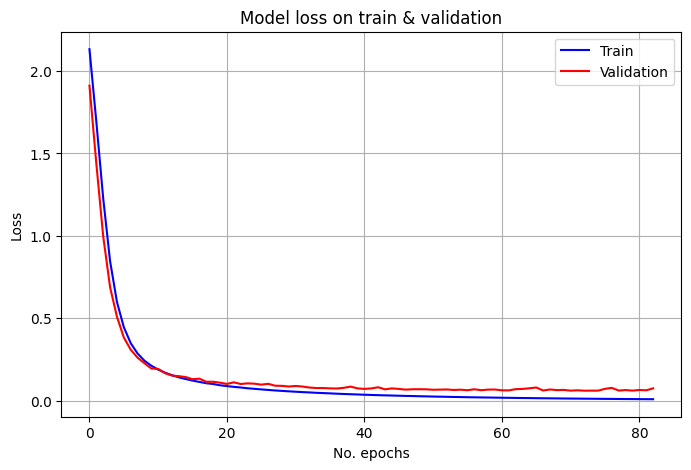

In [106]:
import matplotlib.pyplot as plt

# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('Model loss on train & validation')
plt.xlabel('No. epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss_train, 'b', label = 'Train')
plt.plot(epochs, loss_val, 'r', label = 'Validation')
plt.grid()
plt.legend()

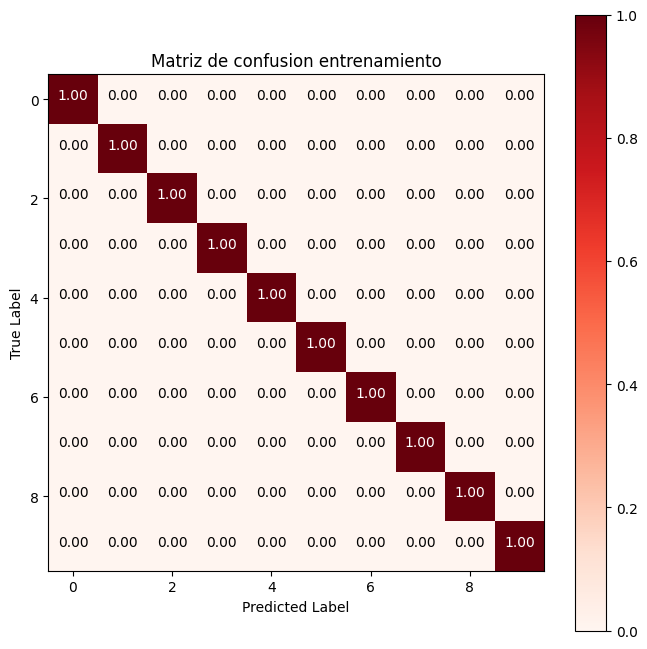

In [107]:
true_labels = []
predicted_labels = []
model.eval()
with torch.no_grad():
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(outputs.argmax(dim=1).cpu().numpy())

conf_matrix = confusion_matrix(true_labels, predicted_labels)
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
plt.imshow(normalized_conf_matrix, interpolation='nearest', cmap='Reds')
plt.title('Matriz de confusion entrenamiento')
plt.colorbar()

for i in range(normalized_conf_matrix.shape[0]):
    for j in range(normalized_conf_matrix.shape[1]):
        plt.text(j, i, "{:.2f}".format(normalized_conf_matrix[i, j]), horizontalalignment='center', color='white' if i == j else 'black')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

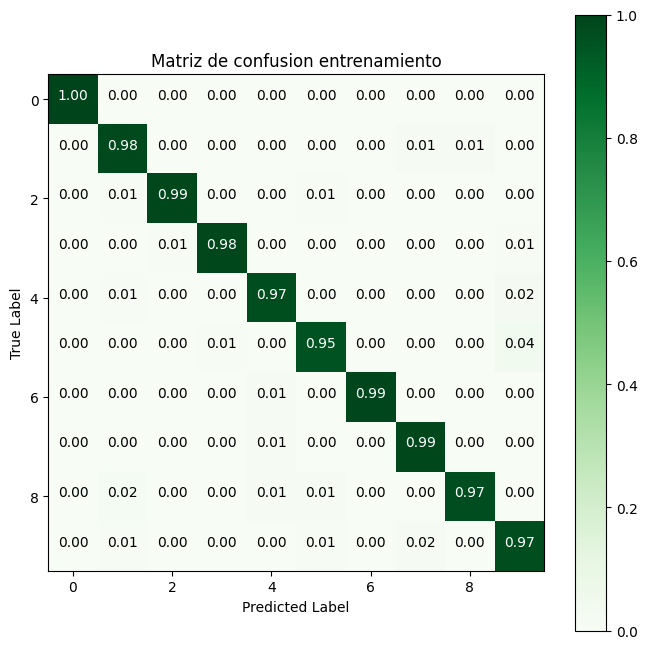

In [108]:
true_labels = []
predicted_labels = []

model.eval()

with torch.no_grad():
    for data in dataloader_val:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(outputs.argmax(dim=1).cpu().numpy())

conf_matrix = confusion_matrix(true_labels, predicted_labels)
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
plt.imshow(normalized_conf_matrix, interpolation='nearest', cmap='Greens')
plt.title('Matriz de confusion entrenamiento')
plt.colorbar()

for i in range(normalized_conf_matrix.shape[0]):
    for j in range(normalized_conf_matrix.shape[1]):
        plt.text(j, i, "{:.2f}".format(normalized_conf_matrix[i, j]), horizontalalignment='center', color='white' if i == j else 'black')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

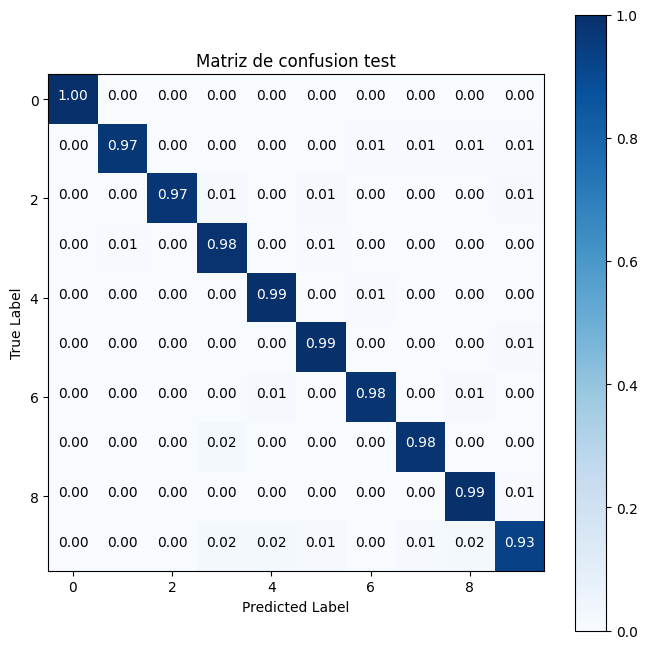

In [109]:
true_labels_test = []
predicted_labels_test = []

# Load the best model's state dictionary
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)  # Move the model to the same device used during training
model.eval()

with torch.no_grad():
    for data in dataloader_test:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)  # Use 'model' to make predictions, not 'best_model'

        true_labels_test.extend(labels.cpu().numpy())
        predicted_labels_test.extend(outputs.argmax(dim=1).cpu().numpy())

conf_matrix_test = confusion_matrix(true_labels_test, predicted_labels_test)

normalized_conf_matrix_test = conf_matrix_test.astype('float') / conf_matrix_test.sum(axis=1)[:, np.newaxis]

accuracy_test = accuracy_score(true_labels_test, predicted_labels_test)

plt.figure(figsize=(8, 8))
plt.imshow(normalized_conf_matrix_test, interpolation='nearest', cmap='Blues')  # You can choose a different colormap
plt.title('Matriz de confusion test')
plt.colorbar()

# Display the accuracy values within the matrix
for i in range(normalized_conf_matrix_test.shape[0]):
    for j in range(normalized_conf_matrix_test.shape[1]):
        plt.text(j, i, "{:.2f}".format(normalized_conf_matrix_test[i, j]), horizontalalignment='center', color='white' if i == j else 'black')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Modelo 10 neuronas en la capa oculta y funcíon de activación Tanh, y 1000 épocas como máximo


##Modelo

In [110]:
model = nn.Sequential(
    nn.Linear(64, 10),  # Capa de entrada con 64 neuronas y capa oculta con 40 neuronas
    nn.Tanh(),  # Función de activación Tanh
    nn.Linear(10, 10)  # Capa oculta con 40 neuronas y capa de salida con 10 neuronas (ajusta la salida según tus necesidades)
)

In [111]:
device = torch.device('cuda')

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Entrenamiento

In [112]:
start = time.time()

best_val_accuracy = 0
loss_train = []
loss_val = []
accuracy_train = []  # Para almacenar el accuracy en entrenamiento
accuracy_val = []    # Para almacenar el accuracy en validación
epochs = []

early_stopping_patience = 10 #numero de veces que puede haber perdida
min_loss_val = float('inf')
patience = 0

# loop
for epoch in range(1000):

  loss_train_batches = []
  loss_val_batches = []
  accuracy_train_batches = []  # Para almacenar el accuracy en cada lote de entrenamiento
  accuracy_val_batches = []    # Para almacenar el accuracy en cada lote de validación
  # Entrenamiento
  model.train()
  # Debemos recorrer cada batch (lote de los datos)
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward() # backpropagation
    optimizer.step()

    # Por completar: calcule la pérdida de validación y acurracy en el batch actual
    loss_train_batches.append(loss.item())
    accuracy_batch = accuracy_score(labels.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy())
    accuracy_train_batches.append(accuracy_batch)  # Almacena la precisión del lote

  loss_train.append(np.mean(loss_train_batches))

  model.eval()

  true_labels_train = []
  predicted_labels_train = []

  with torch.no_grad():
    # Iteramos dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases
      outputs = model(inputs)              # Obtenemos predicciones



      # Guardamos la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())
      accuracy_batch = accuracy_score(labels.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy())
      accuracy_val_batches.append(accuracy_batch)  # Almacena la precisión del lote

  # Guardamos el Loss de validación de la época actual
  loss_val_epoch = np.mean(loss_val_batches)
  loss_val.append(loss_val_epoch)  # Guardar la pérdida de validación en la época actual

  epoch_train_accuracy = np.mean(accuracy_train_batches)
  epoch_val_accuracy = np.mean(accuracy_val_batches)
  accuracy_train.append(epoch_train_accuracy)
  accuracy_val.append(epoch_val_accuracy)

  if epoch_val_accuracy > best_val_accuracy:
      best_val_accuracy = epoch_val_accuracy
      torch.save(model.state_dict(), 'best_model.pth')
  if loss_val_epoch < min_loss_val:
      min_loss_val = loss_val_epoch
      patience = 0  # Restablecer el contador de paciencia si la pérdida de validación mejora
  else:
      patience += 1

  # Guardamos la época
  epochs.append(epoch)

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f accuracy train: %.4f accuracy val: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch], accuracy_train[epoch], accuracy_val[epoch])))

  if patience >= early_stopping_patience:
        print(f"Early stopping after {epoch} epochs")
        break  # Detener el entrenamiento si no hay mejora en la pérdida de validación

end = time.time()
print('Finished Training, total time %f seconds' % (end - start))

Epoch: 0, train loss: 2.2537, val loss: 2.1150 accuracy train: 0.1313 accuracy val: 0.2762
Epoch: 1, train loss: 2.0145, val loss: 1.9065 accuracy train: 0.3600 accuracy val: 0.4430
Epoch: 2, train loss: 1.8214, val loss: 1.7357 accuracy train: 0.4846 accuracy val: 0.5339
Epoch: 3, train loss: 1.6541, val loss: 1.5828 accuracy train: 0.5759 accuracy val: 0.6284
Epoch: 4, train loss: 1.5082, val loss: 1.4426 accuracy train: 0.6590 accuracy val: 0.6924
Epoch: 5, train loss: 1.3805, val loss: 1.3222 accuracy train: 0.7039 accuracy val: 0.7260
Epoch: 6, train loss: 1.2687, val loss: 1.2125 accuracy train: 0.7316 accuracy val: 0.7544
Epoch: 7, train loss: 1.1686, val loss: 1.1175 accuracy train: 0.7612 accuracy val: 0.7906
Epoch: 8, train loss: 1.0788, val loss: 1.0332 accuracy train: 0.7992 accuracy val: 0.8328
Epoch: 9, train loss: 0.9993, val loss: 0.9645 accuracy train: 0.8430 accuracy val: 0.8483
Epoch: 10, train loss: 0.9266, val loss: 0.8774 accuracy train: 0.8638 accuracy val: 0.880

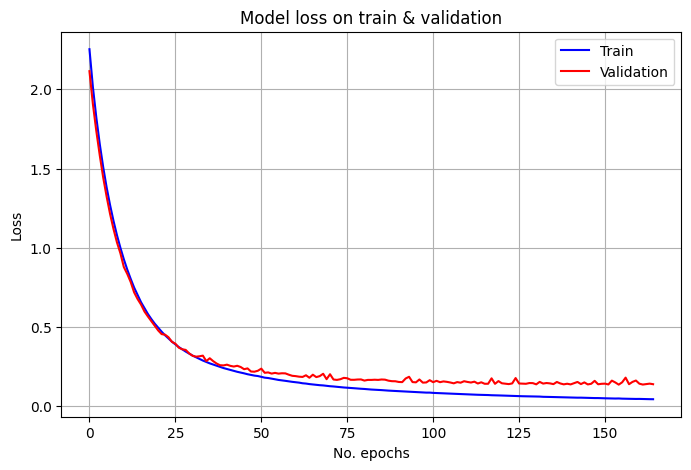

In [113]:
import matplotlib.pyplot as plt

# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('Model loss on train & validation')
plt.xlabel('No. epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss_train, 'b', label = 'Train')
plt.plot(epochs, loss_val, 'r', label = 'Validation')
plt.grid()
plt.legend()

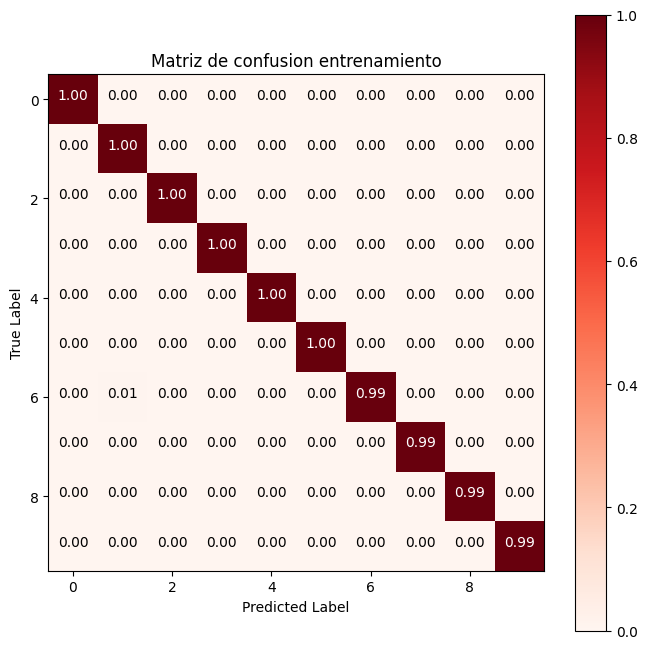

In [114]:
true_labels = []
predicted_labels = []
model.eval()
with torch.no_grad():
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(outputs.argmax(dim=1).cpu().numpy())

conf_matrix = confusion_matrix(true_labels, predicted_labels)
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
plt.imshow(normalized_conf_matrix, interpolation='nearest', cmap='Reds')
plt.title('Matriz de confusion entrenamiento')
plt.colorbar()

for i in range(normalized_conf_matrix.shape[0]):
    for j in range(normalized_conf_matrix.shape[1]):
        plt.text(j, i, "{:.2f}".format(normalized_conf_matrix[i, j]), horizontalalignment='center', color='white' if i == j else 'black')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

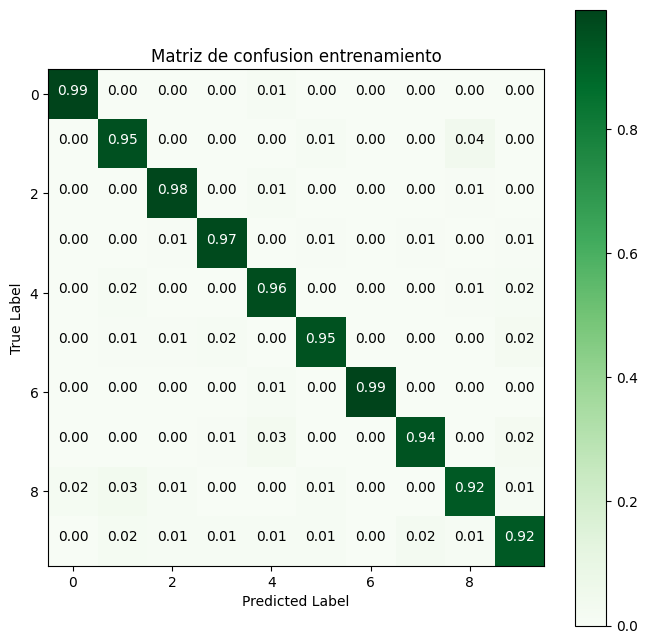

In [115]:
true_labels = []
predicted_labels = []

model.eval()

with torch.no_grad():
    for data in dataloader_val:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(outputs.argmax(dim=1).cpu().numpy())

conf_matrix = confusion_matrix(true_labels, predicted_labels)
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
plt.imshow(normalized_conf_matrix, interpolation='nearest', cmap='Greens')
plt.title('Matriz de confusion entrenamiento')
plt.colorbar()

for i in range(normalized_conf_matrix.shape[0]):
    for j in range(normalized_conf_matrix.shape[1]):
        plt.text(j, i, "{:.2f}".format(normalized_conf_matrix[i, j]), horizontalalignment='center', color='white' if i == j else 'black')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

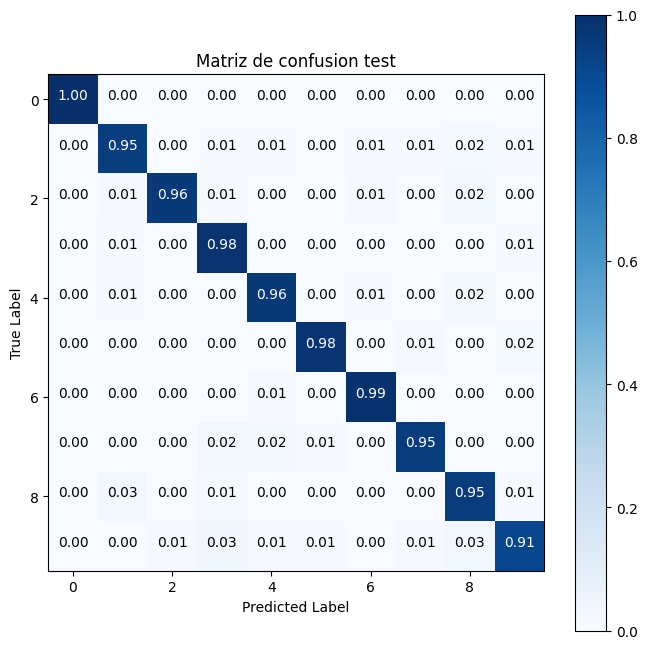

In [116]:
true_labels_test = []
predicted_labels_test = []

# Load the best model's state dictionary
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)  # Move the model to the same device used during training
model.eval()

with torch.no_grad():
    for data in dataloader_test:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)  # Use 'model' to make predictions, not 'best_model'

        true_labels_test.extend(labels.cpu().numpy())
        predicted_labels_test.extend(outputs.argmax(dim=1).cpu().numpy())

conf_matrix_test = confusion_matrix(true_labels_test, predicted_labels_test)

normalized_conf_matrix_test = conf_matrix_test.astype('float') / conf_matrix_test.sum(axis=1)[:, np.newaxis]

accuracy_test = accuracy_score(true_labels_test, predicted_labels_test)

plt.figure(figsize=(8, 8))
plt.imshow(normalized_conf_matrix_test, interpolation='nearest', cmap='Blues')  # You can choose a different colormap
plt.title('Matriz de confusion test')
plt.colorbar()

# Display the accuracy values within the matrix
for i in range(normalized_conf_matrix_test.shape[0]):
    for j in range(normalized_conf_matrix_test.shape[1]):
        plt.text(j, i, "{:.2f}".format(normalized_conf_matrix_test[i, j]), horizontalalignment='center', color='white' if i == j else 'black')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Modelo 40 neuronas en la capa oculta y funcíon de activación Tanh, y 1000 épocas como máximo


##Modelo

In [117]:
model = nn.Sequential(
    nn.Linear(64, 40),  # Capa de entrada con 64 neuronas y capa oculta con 40 neuronas
    nn.Tanh(),  # Función de activación Tanh
    nn.Linear(40, 10)  # Capa oculta con 40 neuronas y capa de salida con 10 neuronas (ajusta la salida según tus necesidades)
)

In [118]:
device = torch.device('cuda')

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Entrenamiento

In [119]:
start = time.time()

best_val_accuracy = 0
loss_train = []
loss_val = []
accuracy_train = []  # Para almacenar el accuracy en entrenamiento
accuracy_val = []    # Para almacenar el accuracy en validación
epochs = []

early_stopping_patience = 10 #numero de veces que puede haber perdida
min_loss_val = float('inf')
patience = 0

# loop
for epoch in range(1000):

  loss_train_batches = []
  loss_val_batches = []
  accuracy_train_batches = []  # Para almacenar el accuracy en cada lote de entrenamiento
  accuracy_val_batches = []    # Para almacenar el accuracy en cada lote de validación
  # Entrenamiento
  model.train()
  # Debemos recorrer cada batch (lote de los datos)
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward() # backpropagation
    optimizer.step()

    # Por completar: calcule la pérdida de validación y acurracy en el batch actual
    loss_train_batches.append(loss.item())
    accuracy_batch = accuracy_score(labels.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy())
    accuracy_train_batches.append(accuracy_batch)  # Almacena la precisión del lote

  loss_train.append(np.mean(loss_train_batches))

  model.eval()

  true_labels_train = []
  predicted_labels_train = []

  with torch.no_grad():
    # Iteramos dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases
      outputs = model(inputs)              # Obtenemos predicciones



      # Guardamos la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())
      accuracy_batch = accuracy_score(labels.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy())
      accuracy_val_batches.append(accuracy_batch)  # Almacena la precisión del lote

  # Guardamos el Loss de validación de la época actual
  loss_val_epoch = np.mean(loss_val_batches)
  loss_val.append(loss_val_epoch)  # Guardar la pérdida de validación en la época actual

  epoch_train_accuracy = np.mean(accuracy_train_batches)
  epoch_val_accuracy = np.mean(accuracy_val_batches)
  accuracy_train.append(epoch_train_accuracy)
  accuracy_val.append(epoch_val_accuracy)

  if epoch_val_accuracy > best_val_accuracy:
      best_val_accuracy = epoch_val_accuracy
      torch.save(model.state_dict(), 'best_model.pth')
  if loss_val_epoch < min_loss_val:
      min_loss_val = loss_val_epoch
      patience = 0  # Restablecer el contador de paciencia si la pérdida de validación mejora
  else:
      patience += 1

  # Guardamos la época
  epochs.append(epoch)

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f accuracy train: %.4f accuracy val: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch], accuracy_train[epoch], accuracy_val[epoch])))

  if patience >= early_stopping_patience:
        print(f"Early stopping after {epoch} epochs")
        break  # Detener el entrenamiento si no hay mejora en la pérdida de validación

end = time.time()
print('Finished Training, total time %f seconds' % (end - start))

Epoch: 0, train loss: 1.9792, val loss: 1.6818 accuracy train: 0.4392 accuracy val: 0.7090
Epoch: 1, train loss: 1.4730, val loss: 1.2455 accuracy train: 0.7749 accuracy val: 0.8256
Epoch: 2, train loss: 1.0955, val loss: 0.9356 accuracy train: 0.8541 accuracy val: 0.8719
Epoch: 3, train loss: 0.8226, val loss: 0.7039 accuracy train: 0.8817 accuracy val: 0.9032
Epoch: 4, train loss: 0.6316, val loss: 0.5526 accuracy train: 0.9099 accuracy val: 0.9217
Epoch: 5, train loss: 0.5001, val loss: 0.4465 accuracy train: 0.9291 accuracy val: 0.9367
Epoch: 6, train loss: 0.4077, val loss: 0.3685 accuracy train: 0.9402 accuracy val: 0.9395
Epoch: 7, train loss: 0.3441, val loss: 0.3226 accuracy train: 0.9481 accuracy val: 0.9408
Epoch: 8, train loss: 0.2976, val loss: 0.2745 accuracy train: 0.9546 accuracy val: 0.9509
Epoch: 9, train loss: 0.2632, val loss: 0.2677 accuracy train: 0.9551 accuracy val: 0.9485
Epoch: 10, train loss: 0.2358, val loss: 0.2216 accuracy train: 0.9580 accuracy val: 0.963

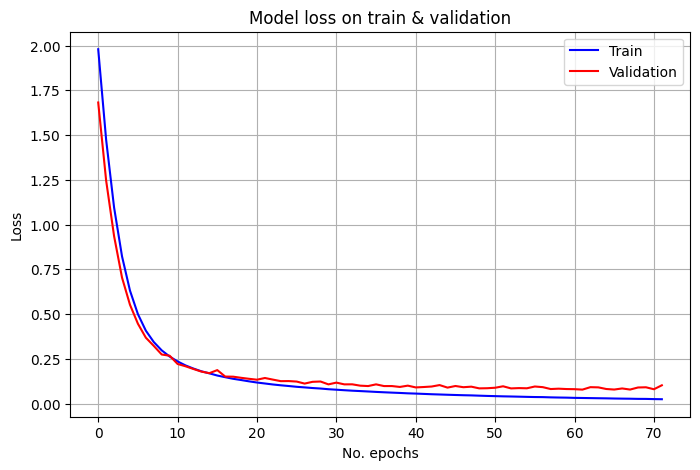

In [120]:
import matplotlib.pyplot as plt

# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('Model loss on train & validation')
plt.xlabel('No. epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss_train, 'b', label = 'Train')
plt.plot(epochs, loss_val, 'r', label = 'Validation')
plt.grid()
plt.legend()

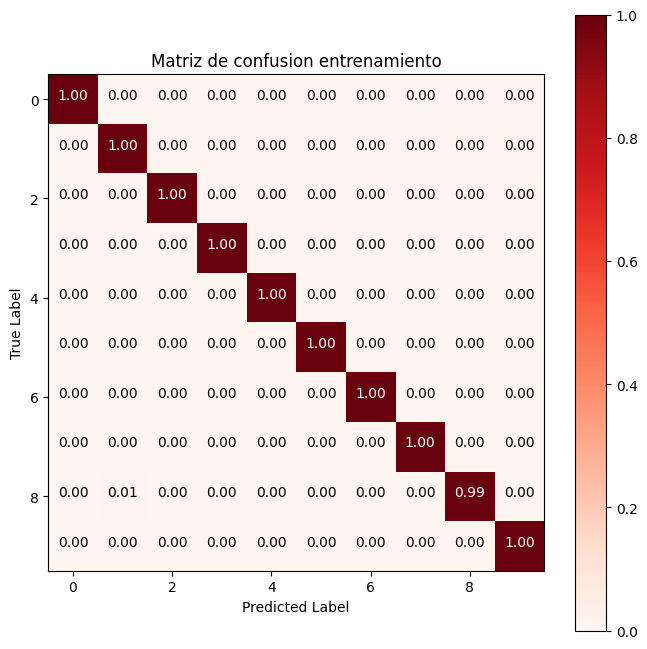

In [121]:
true_labels = []
predicted_labels = []
model.eval()
with torch.no_grad():
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(outputs.argmax(dim=1).cpu().numpy())

conf_matrix = confusion_matrix(true_labels, predicted_labels)
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
plt.imshow(normalized_conf_matrix, interpolation='nearest', cmap='Reds')
plt.title('Matriz de confusion entrenamiento')
plt.colorbar()

for i in range(normalized_conf_matrix.shape[0]):
    for j in range(normalized_conf_matrix.shape[1]):
        plt.text(j, i, "{:.2f}".format(normalized_conf_matrix[i, j]), horizontalalignment='center', color='white' if i == j else 'black')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

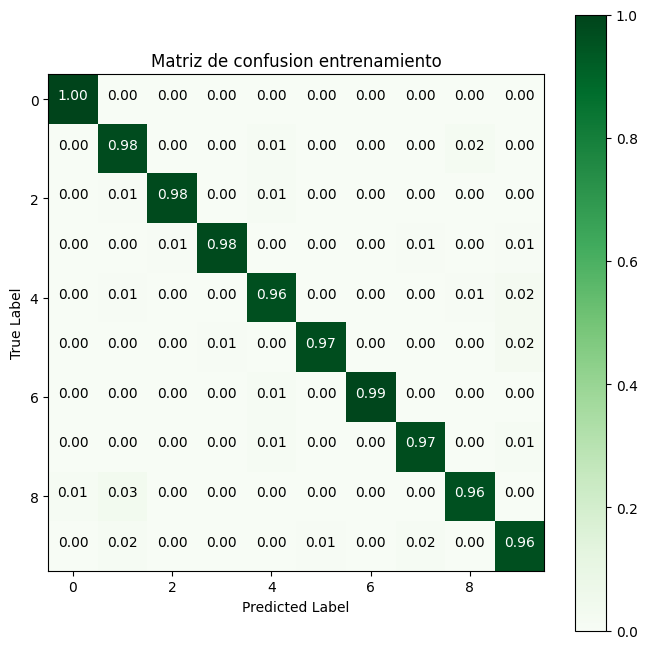

In [122]:
true_labels = []
predicted_labels = []

model.eval()

with torch.no_grad():
    for data in dataloader_val:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(outputs.argmax(dim=1).cpu().numpy())

conf_matrix = confusion_matrix(true_labels, predicted_labels)
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
plt.imshow(normalized_conf_matrix, interpolation='nearest', cmap='Greens')
plt.title('Matriz de confusion entrenamiento')
plt.colorbar()

for i in range(normalized_conf_matrix.shape[0]):
    for j in range(normalized_conf_matrix.shape[1]):
        plt.text(j, i, "{:.2f}".format(normalized_conf_matrix[i, j]), horizontalalignment='center', color='white' if i == j else 'black')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

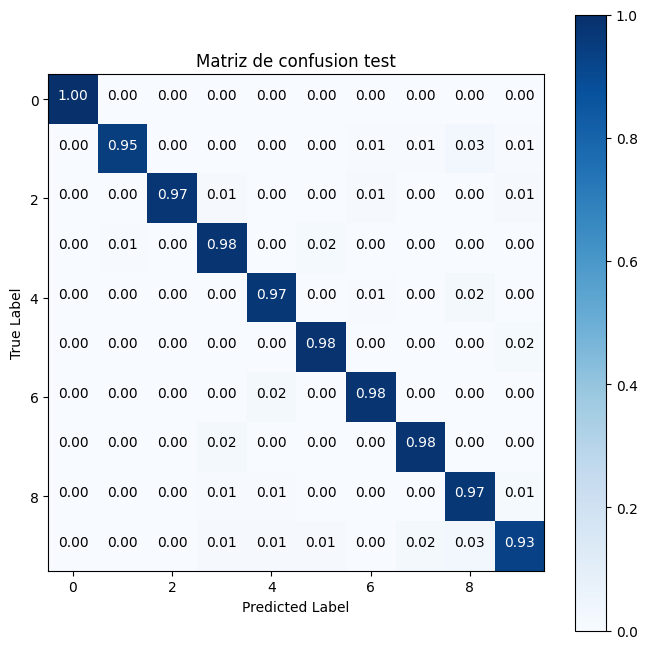

In [123]:
true_labels_test = []
predicted_labels_test = []

# Load the best model's state dictionary
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)  # Move the model to the same device used during training
model.eval()

with torch.no_grad():
    for data in dataloader_test:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)  # Use 'model' to make predictions, not 'best_model'

        true_labels_test.extend(labels.cpu().numpy())
        predicted_labels_test.extend(outputs.argmax(dim=1).cpu().numpy())

conf_matrix_test = confusion_matrix(true_labels_test, predicted_labels_test)

normalized_conf_matrix_test = conf_matrix_test.astype('float') / conf_matrix_test.sum(axis=1)[:, np.newaxis]

accuracy_test = accuracy_score(true_labels_test, predicted_labels_test)

plt.figure(figsize=(8, 8))
plt.imshow(normalized_conf_matrix_test, interpolation='nearest', cmap='Blues')  # You can choose a different colormap
plt.title('Matriz de confusion test')
plt.colorbar()

# Display the accuracy values within the matrix
for i in range(normalized_conf_matrix_test.shape[0]):
    for j in range(normalized_conf_matrix_test.shape[1]):
        plt.text(j, i, "{:.2f}".format(normalized_conf_matrix_test[i, j]), horizontalalignment='center', color='white' if i == j else 'black')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Modelo 2 capas ocultas con 40 y 40 neuronas cada una y funcíon de activación ReLU, y 1000 épocas como máximo



##Modelo

In [124]:
model = nn.Sequential(
    nn.Linear(64, 40),  # Capa de entrada con 64 neuronas y primera capa oculta con 40 neuronas
    nn.ReLU(),  # Función de activación ReLU
    nn.Linear(40, 40),  # Segunda capa oculta con 40 neuronas
    nn.ReLU(),  # Función de activación ReLU
    nn.Linear(40, 10)  # Capa de salida con 10 neuronas (ajusta la salida según tus necesidades)
)

In [125]:
device = torch.device('cuda')

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Entrenamiento

In [126]:
start = time.time()

best_val_accuracy = 0
loss_train = []
loss_val = []
accuracy_train = []  # Para almacenar el accuracy en entrenamiento
accuracy_val = []    # Para almacenar el accuracy en validación
epochs = []

early_stopping_patience = 10 #numero de veces que puede haber perdida
min_loss_val = float('inf')
patience = 0

# loop
for epoch in range(1000):

  loss_train_batches = []
  loss_val_batches = []
  accuracy_train_batches = []  # Para almacenar el accuracy en cada lote de entrenamiento
  accuracy_val_batches = []    # Para almacenar el accuracy en cada lote de validación
  # Entrenamiento
  model.train()
  # Debemos recorrer cada batch (lote de los datos)
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward() # backpropagation
    optimizer.step()

    # Por completar: calcule la pérdida de validación y acurracy en el batch actual
    loss_train_batches.append(loss.item())
    accuracy_batch = accuracy_score(labels.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy())
    accuracy_train_batches.append(accuracy_batch)  # Almacena la precisión del lote

  loss_train.append(np.mean(loss_train_batches))

  model.eval()

  true_labels_train = []
  predicted_labels_train = []

  with torch.no_grad():
    # Iteramos dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases
      outputs = model(inputs)              # Obtenemos predicciones



      # Guardamos la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())
      accuracy_batch = accuracy_score(labels.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy())
      accuracy_val_batches.append(accuracy_batch)  # Almacena la precisión del lote

  # Guardamos el Loss de validación de la época actual
  loss_val_epoch = np.mean(loss_val_batches)
  loss_val.append(loss_val_epoch)  # Guardar la pérdida de validación en la época actual

  epoch_train_accuracy = np.mean(accuracy_train_batches)
  epoch_val_accuracy = np.mean(accuracy_val_batches)
  accuracy_train.append(epoch_train_accuracy)
  accuracy_val.append(epoch_val_accuracy)

  if epoch_val_accuracy > best_val_accuracy:
      best_val_accuracy = epoch_val_accuracy
      torch.save(model.state_dict(), 'best_model.pth')
  if loss_val_epoch < min_loss_val:
      min_loss_val = loss_val_epoch
      patience = 0  # Restablecer el contador de paciencia si la pérdida de validación mejora
  else:
      patience += 1

  # Guardamos la época
  epochs.append(epoch)

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f accuracy train: %.4f accuracy val: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch], accuracy_train[epoch], accuracy_val[epoch])))

  if patience >= early_stopping_patience:
        print(f"Early stopping after {epoch} epochs")
        break  # Detener el entrenamiento si no hay mejora en la pérdida de validación

end = time.time()
print('Finished Training, total time %f seconds' % (end - start))

Epoch: 0, train loss: 2.1921, val loss: 2.0408 accuracy train: 0.3456 accuracy val: 0.5438
Epoch: 1, train loss: 1.8165, val loss: 1.5482 accuracy train: 0.6319 accuracy val: 0.7219
Epoch: 2, train loss: 1.2262, val loss: 0.9497 accuracy train: 0.7747 accuracy val: 0.7970
Epoch: 3, train loss: 0.7228, val loss: 0.5514 accuracy train: 0.8526 accuracy val: 0.8776
Epoch: 4, train loss: 0.4329, val loss: 0.3580 accuracy train: 0.9039 accuracy val: 0.9131
Epoch: 5, train loss: 0.2933, val loss: 0.2740 accuracy train: 0.9298 accuracy val: 0.9215
Epoch: 6, train loss: 0.2247, val loss: 0.2244 accuracy train: 0.9472 accuracy val: 0.9394
Epoch: 7, train loss: 0.1831, val loss: 0.2124 accuracy train: 0.9548 accuracy val: 0.9429
Epoch: 8, train loss: 0.1535, val loss: 0.1619 accuracy train: 0.9619 accuracy val: 0.9567
Epoch: 9, train loss: 0.1324, val loss: 0.1483 accuracy train: 0.9669 accuracy val: 0.9552
Epoch: 10, train loss: 0.1164, val loss: 0.1361 accuracy train: 0.9721 accuracy val: 0.960

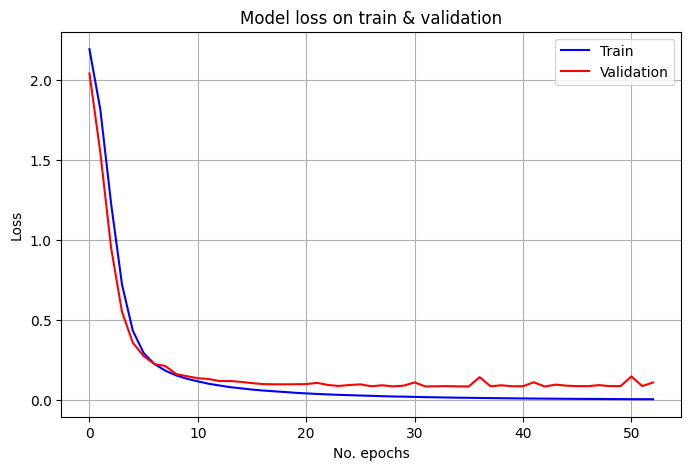

In [127]:
import matplotlib.pyplot as plt

# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('Model loss on train & validation')
plt.xlabel('No. epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss_train, 'b', label = 'Train')
plt.plot(epochs, loss_val, 'r', label = 'Validation')
plt.grid()
plt.legend()

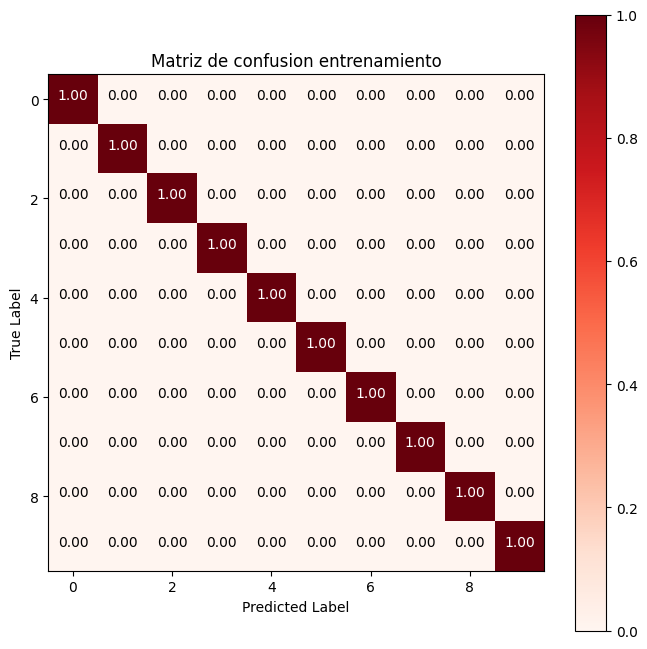

In [128]:
true_labels = []
predicted_labels = []
model.eval()
with torch.no_grad():
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(outputs.argmax(dim=1).cpu().numpy())

conf_matrix = confusion_matrix(true_labels, predicted_labels)
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
plt.imshow(normalized_conf_matrix, interpolation='nearest', cmap='Reds')
plt.title('Matriz de confusion entrenamiento')
plt.colorbar()

for i in range(normalized_conf_matrix.shape[0]):
    for j in range(normalized_conf_matrix.shape[1]):
        plt.text(j, i, "{:.2f}".format(normalized_conf_matrix[i, j]), horizontalalignment='center', color='white' if i == j else 'black')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

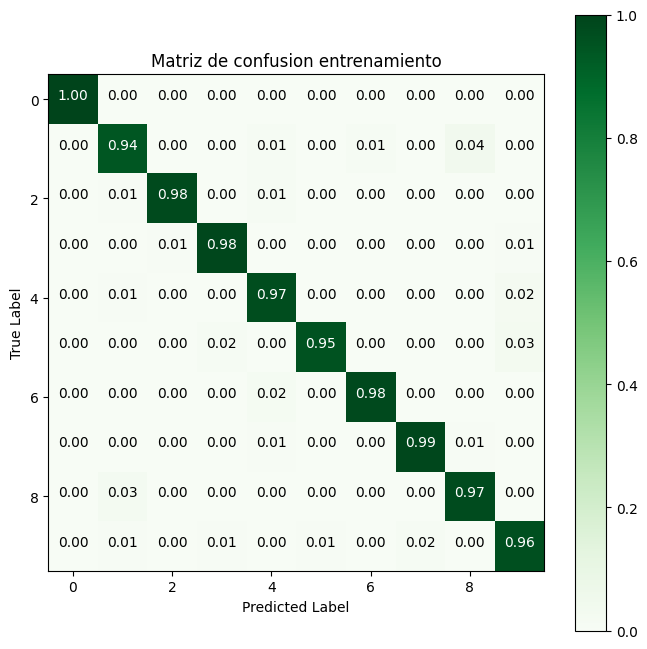

In [129]:
true_labels = []
predicted_labels = []

model.eval()

with torch.no_grad():
    for data in dataloader_val:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(outputs.argmax(dim=1).cpu().numpy())

conf_matrix = confusion_matrix(true_labels, predicted_labels)
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
plt.imshow(normalized_conf_matrix, interpolation='nearest', cmap='Greens')
plt.title('Matriz de confusion entrenamiento')
plt.colorbar()

for i in range(normalized_conf_matrix.shape[0]):
    for j in range(normalized_conf_matrix.shape[1]):
        plt.text(j, i, "{:.2f}".format(normalized_conf_matrix[i, j]), horizontalalignment='center', color='white' if i == j else 'black')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

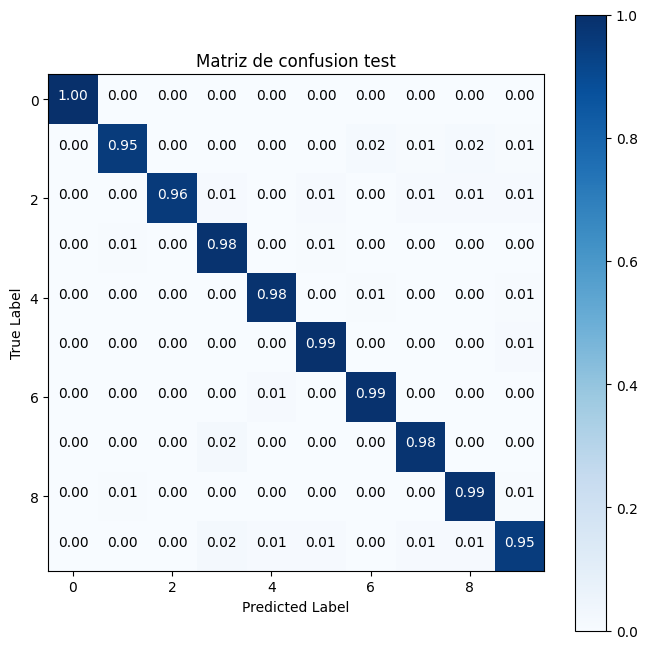

In [130]:
true_labels_test = []
predicted_labels_test = []

# Load the best model's state dictionary
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)  # Move the model to the same device used during training
model.eval()

with torch.no_grad():
    for data in dataloader_test:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)  # Use 'model' to make predictions, not 'best_model'

        true_labels_test.extend(labels.cpu().numpy())
        predicted_labels_test.extend(outputs.argmax(dim=1).cpu().numpy())

conf_matrix_test = confusion_matrix(true_labels_test, predicted_labels_test)

normalized_conf_matrix_test = conf_matrix_test.astype('float') / conf_matrix_test.sum(axis=1)[:, np.newaxis]

accuracy_test = accuracy_score(true_labels_test, predicted_labels_test)

plt.figure(figsize=(8, 8))
plt.imshow(normalized_conf_matrix_test, interpolation='nearest', cmap='Blues')  # You can choose a different colormap
plt.title('Matriz de confusion test')
plt.colorbar()

# Display the accuracy values within the matrix
for i in range(normalized_conf_matrix_test.shape[0]):
    for j in range(normalized_conf_matrix_test.shape[1]):
        plt.text(j, i, "{:.2f}".format(normalized_conf_matrix_test[i, j]), horizontalalignment='center', color='white' if i == j else 'black')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#Analisis

a)La cantidad de neuronas en la capa oculta es un hiperparámetro crítico en la configuración de una red neuronal y puede tener un impacto significativo en el rendimiento de la red normalmente se presenta como.

Subajuste (Underfitting):

Pocas neuronas: Muy pocas neuronas en la capa oculta, la red puede tener dificultades para aprender patrones en los datos. Esto puede llevar a un subajuste, donde la red no puede representar adecuadamente la relación entre las entradas y las salidas. Tendrá un bajo rendimiento tanto en el conjunto de entrenamiento como en el conjunto de prueba.
Sobreajuste (Overfitting):

Demasiadas neuronas: Exceso de neuronas en la capa oculta, la red puede volverse demasiado compleja y memorizar el conjunto de entrenamiento en lugar de generalizar a nuevos datos. El modelo se ajusta en exceso a ruido o características irrelevantes en los datos de entrenamiento. En este caso, el rendimiento en el conjunto de entrenamiento puede ser alto, pero el rendimiento en el conjunto de prueba será bajo.

b)La cantidad de capas ocultas en una red neuronal, también conocida como profundidad de la red, es otro hiperparámetro crítico que puede tener un impacto significativo en el desempeño de la red. Normalmente se presentan como.

Redes poco profundas:

Menos capas ocultas: Una red con pocas capas ocultas, generalmente se considera poco profunda. Esto puede hacer que la red sea incapaz de capturar patrones en los datos. La falta de profundidad puede limitar la capacidad de representación de la red y, como resultado, puede tener dificultades para modelar relaciones no lineales en los datos. Esto puede llevar a que la red no se ajusta adecuadamente a los datos.

Redes profundas:

Más capas ocultas: A medida que agregas más capas ocultas a la red, esta se vuelve más profunda. Las redes profundas tienen la capacidad de aprender representaciones jerárquicas de datos, lo que puede ser beneficioso para capturar patrones y características más abstractas y complejas. Pero entrenar redes profundas puede ser más desafiante y propenso a problemas como el desvanecimiento del gradiente o la explosión del gradiente.

c)La elección de la función de activación es un aspecto crítico en el diseño de redes neuronales, y puede tener un profundo impacto en el rendimiento y la capacidad de la red para aprender y generalizar a partir de los datos. La no linealidad introducida por la función de activación es esencial para que la red pueda modelar relaciones no lineales en los datos. La función de activación también puede influir en la velocidad de convergencia y la capacidad de la red para evitar problemas de saturación y desvanecimiento del gradiente. La selección de la función de activación adecuada debe basarse en la naturaleza de la tarea y la experimentación en el diseño de la arquitectura de la red.




